In [ ]:
# Wrong using of ~
# ~unsigned i, gives an extral large value

In [1]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from IPython.display import Image as display_image
from okiya import draw_tiles, bin_interpretation, split_list_n, unzip, turn_number

In [2]:
player = 0 # Red player
#player = 1 # Black player

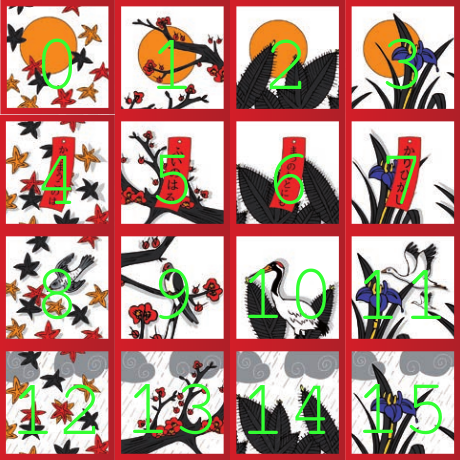

In [3]:
tiles = np.array([i for i in range(0,16)]).reshape([4,4])
img_path = draw_tiles(tiles, draw_numbers = True, hi_res = False)
display_image(img_path)

In [4]:
init_tiles = np.array([
    [8,1,3,15],
    [9,10,12,2],
    [14,6,5,0],
    [11,4,7,13]
])
img_path = draw_tiles(init_tiles, draw_numbers = False, hi_res = False)
display_image(img_path)

# prepare for gpu
init_tiles_array = []
for row in init_tiles:
    init_tiles_array = np.concatenate((init_tiles_array, row), axis=0)
init_tiles_gpu = gpuarray.to_gpu(init_tiles_array.astype(np.int32))

In [5]:
len(bin_interpretation(2147483647))

31

В карте 1080-ti, MAX_GRID_DIM_X = 2 147 483 647, что позволяет обрабатывать за один такт 2 млрд комбинаций.  
Упаковать их можно в 31 бите.  
План действий:  
1. Вычисляем общее количество возможных победных комбинаций на последнем ходе: 2145. Это 12 бит.  
2. Задаем изначальное расположение тайлов на поле  
3. Все комбинации маски поля это 16 единиц, или 16 бит.  
4. Для каждого хода, передаем в ядро:  
- Игрок, победа которого нас интересует: 0 или 1  
- Текущий ход: от 0 до 15  
- Расположение тайлов игры и фишек игроков: 16 значений от 0 до 17. 16 и 17 значения - фишки игроков.
- Входной вектор смещений побед: 2145  
- Выходной вектор: Пакет побед и комбинаций маски  
Каждый ход ядро опускается до текущего хода.  
Потоков не хватит для охвата всех вариантов первых ходов. Но это и не требуется. Ядро вызывается со смещением в поле вариантов. Исследуется только указанное окно. Поиск производится в различных окнах до тех пор, пока не будет найдено хотя бы одно победное решение. Случайное решение предлагается игроку, затем ждем хода противника и последовательность повторяется. 

# Вычислим смещения победных комбинаций

In [6]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__global__ void get_win_bias(int player, float *out_vec)
{
    // Идентификатор блока-потока
    unsigned int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    // Убедимся, что число единиц и нулей в комбинации соответствует ходу
    int ones = 0;
    for(int a=0;a<16;a++) if ((((int)round(pow(2,a)))&i)>0) ones++;
    
    // Проверим, победна ли комбинация выбранного игрока среди возможных
    unsigned int win_tester;
    if (player) win_tester = i;
    else win_tester = ~i;
    if (ones==8 && win_combination(win_tester) && !win_combination(~win_tester)) out_vec[i] = 1;
}
""")

In [7]:
256*256

65536

In [8]:
tail_count = 1
256*256*(16**tail_count)

1048576

In [9]:
(2097151*1024)>>16

32767

In [10]:
bin_interpretation(int('1000011000011111111111111111',2)>>16)

'100001100001'

In [11]:
combination_check_gpu = ker.get_function("get_win_bias")

combinations = np.zeros(256*256).astype(np.float32)
#turn_id_gpu = np.int32(15)

combinations_gpu_out = gpuarray.to_gpu(combinations)


combination_check_gpu(    
    np.int32(player),
    #turn_id_gpu,
    #init_tiles_gpu,
    combinations_gpu_out,
    block=(256,1,1),
    grid=(256,1,1)
)

In [12]:
out_combinations = combinations_gpu_out.get()
win_combinations = np.where(out_combinations == 1)[0]
print('Количество победных комбинаций:', len(win_combinations))

Количество победных комбинаций: 2145


In [13]:
win_combinations[0], bin_interpretation(win_combinations[0], lead_zero_count=16)

(983, '0000001111010111')

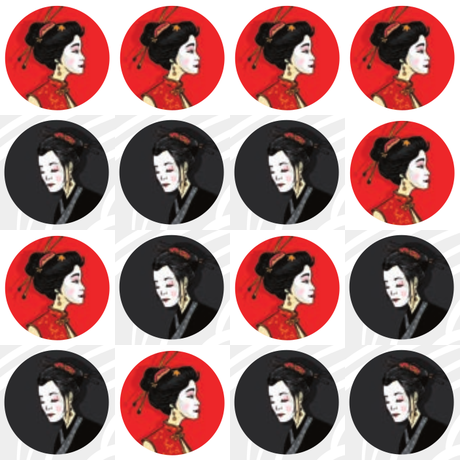

In [14]:
i = 100 # get a 100-th combination, for example
i_bin = bin_interpretation(win_combinations[i], lead_zero_count=16)
tiles = np.array([int(j) for j in i_bin]).reshape([4,4])+16 # 16 is player image bias
draw_tiles(tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")

# Выбор хода

Итак, для любого хода нам потребуется хранить:  
- Маску: 16 бит  
- Ссылки на смещения побед: 12 бит  
Всего 27 бит

In [15]:
#MAX_GRID_DIM_X: 2147483647
bit_27 = int(''.join(['1' for i in range(16+12)]),2)
print('27 бит в десятичном представлении:', bit_27)

27 бит в десятичном представлении: 268435455


In [16]:
grid_size = np.ceil(bit_27/1024).astype(int)
print('размер сетки:', grid_size)

размер сетки: 262144


1. В это ядро передается:
- Игрок, победа которого нас интересует: 0 или 1  
- Текущий ход: от 0 до 15  
- Расположение тайлов игры и фишек игроков: 16 значений от 0 до 17. 16 и 17 значения - фишки игроков  
- Входной вектор смещений побед: 2145 (константа)  
- Выходной вектор: Пакет победных комбинаций маски  
  
2. Из пакета комбинаций маски выбирается случайная и предлагается игроку  
3. Наш игрок Делает ход  
4. Противник делает ход  
5. Переход к п.1

In [208]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__device__ int ones_counter(unsigned int i)
{
    unsigned int ones = 0;
    unsigned int a = 1;
    for(int b=0;b<16;b++)
    {
        if (a&i) ones++;
        a = a*2;
    }
    return(ones);
}

__global__ void turn(int player, int turn_id, int *init_tiles, int *win_bias, float *out_vec, unsigned int *debug_a)
{
    // Нулевые ячейки
    //unsigned int zeros[16] = {32767,49151,57343,61439,63487,64511,65023,65279,65407,65471,65503,65519,65527,65531,65533,65534};
    
    // Связи тайлов
    unsigned char relations[16][6] = {
    { 1,  2,  3,  4,  8, 12}, 
    { 0,  2,  3,  5,  9, 13}, 
    { 0,  1,  3,  6, 10, 14}, 
    { 0,  1,  2,  7, 11, 15}, 
    { 0,  5,  6,  7,  8, 12}, 
    { 1,  4,  6,  7,  9, 13}, 
    { 2,  4,  5,  7, 10, 14}, 
    { 3,  4,  5,  6, 11, 15}, 
    { 0,  4,  9, 10, 11, 12}, 
    { 1,  5,  8, 10, 11, 13}, 
    { 2,  6,  8,  9, 11, 14}, 
    { 3,  7,  8,  9, 10, 15}, 
    { 0,  4,  8, 13, 14, 15}, 
    { 1,  5,  9, 12, 14, 15}, 
    { 2,  6, 10, 12, 13, 15}, 
    { 3,  7, 11, 12, 13, 14}
    };
    
    // Количество фишек нулевого игрока на каждом ходу игры
    unsigned char turn_player_a_count[16] = {1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8};
    
    // Количество фишек первого игрока на каждом ходу игры
    //unsigned char turn_player_b_count[16] = {0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8};
    
    // Идентификатор блока-потока
    unsigned int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    //Распаковка идентификаторов игры    
    unsigned int comb = i>>16; // bias_12: >100001100001< mask_16: [1111111111111111]
    unsigned int mask = i&65535; // bias_12: [100001100001] mask_16: >1111111111111111<
    unsigned char tail_count = 15-turn_id;
    
    if (comb<2145) //2145 - game constant of win combinations count
    {        
        comb = win_bias[comb]; //Текущая комбинация, безусловно одна из победных                
        
        // Убедимся, что число тайлов в маске соответствует ходу
        if (ones_counter(mask)==tail_count)
        {            
            // Погасим фишки игрока тайлами маски            
            comb = comb&~mask;
            
            // Убедимся, что число единиц и нулей в комбинации соответствует ходу
            if (ones_counter(comb)==turn_player_a_count[turn_id])            
            {                
                // Проверим, победна ли комбинация выбранного игрока среди возможных
                unsigned int win_tester;
                if (player==1) win_tester = comb;
                else win_tester = ~comb;
                if (win_combination(win_tester) && !win_combination(~win_tester)) 
                    {
                    out_vec[i] = 1;
                    debug_a[i] = 1;
                    }
                
            }
        }
    }
}
""")

<ipython-input-208-867d1fbdc180>:1: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(46): warning #177-D: variable "relations" was declared but never referenced


  ker = SourceModule("""


# 14

In [ ]:
turn_gpu = ker.get_function("turn")

combinations = np.zeros(1024*262144).astype(np.float32) # 12+16 bytes
turn_id_gpu = np.int32(14)

win_combinations_gpu = gpuarray.to_gpu(win_combinations)
combinations_gpu_out = gpuarray.to_gpu(combinations)

turn_gpu(
    np.int32(player),
    turn_id_gpu,
    init_tiles_gpu,
    win_combinations_gpu,
    combinations_gpu_out,    
    block=(1024,1,1),
    grid=(262144,1,1)
)

In [ ]:
out_combinations = combinations_gpu_out.get()
win_combinations_of_turn = np.where(out_combinations == 1)[0]
print('Количество победных комбинаций:', len(win_combinations_of_turn))

In [ ]:
turn_comb, turn_mask = unzip(win_combinations_of_turn[100]) # get a 100-th combination, for example

i_bin = bin_interpretation(win_combinations[turn_comb], lead_zero_count=16)
tiles = np.array([int(j) for j in i_bin]).reshape([4,4])+16 # 16 is player image bias

# apply init tiles mask
tiles = list(np.reshape(tiles,16))
pos = 0
for i in bin_interpretation(turn_mask, lead_zero_count=16):
    if int(i):
        tiles[pos]=list(np.reshape(init_tiles,16))[pos]
    pos += 1
tiles = np.reshape(tiles,[4,4])

# draw
draw_tiles(tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")

# 3

In [209]:
turn_gpu = ker.get_function("turn")

combinations = np.zeros(1024*262144).astype(np.float32) # 12+16 bytes
turn_id_gpu = np.int32(12)

win_combinations_gpu = gpuarray.to_gpu(win_combinations)
combinations_gpu_out = gpuarray.to_gpu(combinations)
debug_a_gpu = gpuarray.to_gpu(np.zeros(1024*262144).astype(np.int32))

turn_gpu(
    np.int32(player),
    turn_id_gpu,
    init_tiles_gpu,
    win_combinations_gpu,
    combinations_gpu_out,
    debug_a_gpu,
    block=(1024,1,1),
    grid=(262144,1,1)
)

out_combinations = combinations_gpu_out.get()
win_combinations_of_turn = np.where(out_combinations == 1)[0]
print('Количество победных комбинаций:', len(win_combinations_of_turn))

Количество победных комбинаций: 240352


In [210]:
debug_a = debug_a_gpu.get()

In [139]:
bin_interpretation(2144)

'100001100000'

In [140]:
int('111111000000',2)

4032

In [201]:
debug_a[0]

0

In [211]:
np.where(debug_a >0)[0]

array([       41,        42,        44, ..., 140558848, 140559360,
       140566528])

In [212]:
debug_found = debug_a[np.where(debug_a>0)[0]]
set(debug_found)

{1}

In [213]:
len(combinations), len(debug_a_gpu), len(debug_a), len(debug_found)

(268435456, 268435456, 268435456, 240352)

In [145]:
debug_found[-10:]

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)

In [146]:
win_combinations[-1:]

array([60352])

In [147]:
### Debug++
def debug_ones_counter(i):
    ones = 0
    a = 1
    for b in range(16):
        if a&i:
            ones+=1
        a = a*2
    return ones

In [148]:
bin_interpretation(debug_found[-1:][0]), debug_ones_counter(debug_found[-1:][0])

('111', 3)

In [149]:
print(i_bin)
print(bin_interpretation(turn_mask, lead_zero_count=16))
print(debug_ones_counter(int(i_bin,2)))
print(debug_ones_counter(int(i_bin,2)&turn_mask))
### Debug--

0000001111010111
0010010001000000
8
1


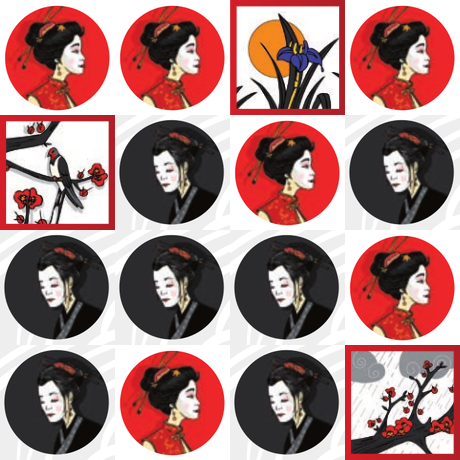

In [192]:
turn_comb, turn_mask = unzip(win_combinations_of_turn[1000]) # get a 100-th combination, for example

i_bin = bin_interpretation(win_combinations[turn_comb], lead_zero_count=16)
tiles = np.array([int(j) for j in i_bin]).reshape([4,4])+16 # 16 is player image bias

# apply init tiles mask
tiles = list(np.reshape(tiles,16))
pos = 0
for i in bin_interpretation(turn_mask, lead_zero_count=16):
    if int(i):
        tiles[pos]=list(np.reshape(init_tiles,16))[pos]
    pos += 1
tiles = np.reshape(tiles,[4,4])

# draw
draw_tiles(tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")

In [151]:
turn_comb, turn_mask, bin_interpretation(turn_mask)

(0, 9280, '10010001000000')

In [168]:
def win_combination(i):
    win = [
    61440, ## row 0
    3840,  ## row 1
    240,   ## row 2
    15,    ## row 3
    34952, ## col 0
    17476, ## col 1
    8738,  ## col 2
    4369,  ## col 3
    52224, ## quad 0
    26112, ## quad 1
    13056, ## quad 2
    3264,  ## quad 3
    1632,  ## quad 4
    816,   ## quad 5
    204,   ## quad 6
    102,   ## quad 7
    51     ## quad 8
    ]
    for a in range(16):
        if ((i&win[a])==win[a]):
            return True
    return False

In [188]:
bin_interpretation(983, lead_zero_count=16)

'0000001111010111'

In [180]:
win_combinations[turn_comb], win_combination(win_combinations[turn_comb])

(983, False)

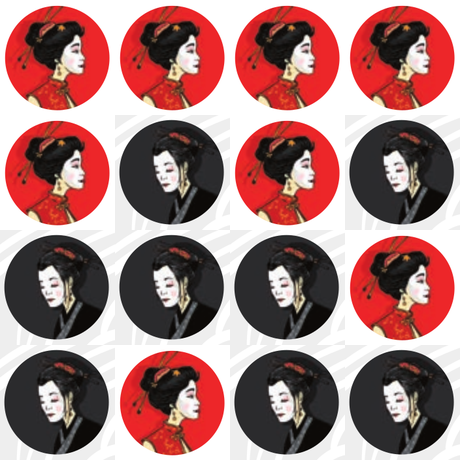

In [194]:
turn_comb, turn_mask = unzip(win_combinations_of_turn[1000]) # get a 100-th combination, for example

i_bin = bin_interpretation(win_combinations[turn_comb], lead_zero_count=16)
tiles = np.array([int(j) for j in i_bin]).reshape([4,4])+16 # 16 is player image bias
# draw
draw_tiles(tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")

In [219]:
int(''.join(['1' for i in range(16)]),2)

65535

In [220]:
bin_interpretation(4294963263)

'11111111111111111111000000111111'